<a href="https://colab.research.google.com/github/tonimgomes/Build-Detection-with-LiDAR/blob/main/Conjunto_1_Classifica%C3%A7%C3%A3o_Multiclasse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Instalações e Importações



In [ ]:
pip install pandas scikit-learn


In [ ]:
pip install openpyxl

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


# Modelo de predição


## Importando o dataset de amostras aleatórias

In [ ]:
df_xlsx = pd.read_excel("caminho/para/seu/dataset")
df_csv = pd.read_csv("caminho/para/seu/dataset")

In [ ]:
# Exibir as primeiras linhas do DataFrame
print(df_xlsx.head())
# Informações sobre o DataFrame
print(df_xlsx.info())
# Verificar valores ausentes em todas as colunas
print(df_xlsx.isnull().sum())




## Pré-processamento dos dados do dataset
É importante realizar esse pré processamento a fim de verificar se as colunas de interesse (Telhado e Alvo) estão com dados válidos. As etapas a seguir incluem a remoção de células que apresentam valores nulos em Telhado e Alvo, remoção de colunas que não serão utilizadas na classificação e renomeação de colunas para um melhor entendimento dos atributos.

In [ ]:
#Excluir valores ausentes na classe Alvo e Telhado simultâneamente
df_xlsx_cleaned = df_xlsx.dropna(subset=['Alvo', 'Telhado'])

#Excluir colunas Fid, Telhado e OUTPUT_4 que não serão utilizadas no código
df_xlsx_cleaned.drop(columns=['fid'], inplace=True)
df_xlsx_cleaned.drop(columns=['Telhado'], inplace=True)
df_xlsx_cleaned.drop(columns=['OUTPUT_4'], inplace=True)

#Renomear as colunas
df_xlsx_cleaned.rename(columns={'intensity_resampled_rec': 'Intensidade'}, inplace=True)
df_xlsx_cleaned.rename(columns={'OUTPUT_1': 'R'}, inplace=True)
df_xlsx_cleaned.rename(columns={'OUTPUT_2': 'G'}, inplace=True)
df_xlsx_cleaned.rename(columns={'OUTPUT_3': 'B'}, inplace=True)
df_xlsx_cleaned.rename(columns={'textura_glcm_entropy': 'Entropia'}, inplace=True)
df_xlsx_cleaned.rename(columns={'textura_glcm_ASM': 'ASM'}, inplace=True)
df_xlsx_cleaned.rename(columns={'textura_glcm_correlation': 'Correlacao'}, inplace=True)


In [ ]:
# Informações sobre o DataFrame pré processado
print(df_xlsx_cleaned.info())

# Verificar valores ausentes em todas as colunas
print(df_xlsx_cleaned.isnull().sum())

#Salvar dataset pré processado
df_xlsx_cleaned.to_excel('caminho/para/salvar/seu/dataset', index=False)



## Criando o conjunto de treinamento e teste a partir do Stratified Shuffle
O Stratified Shuffle (embaralhamento estratificado) é uma técnica usada na amostragem de dados, para garantir que as proporções de classes no conjunto de dados original sejam preservadas nos conjuntos de treinamento e teste após a divisão.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import time

# Separar features (X) e rótulos (y)
X = df_xlsx_cleaned.drop('Alvo', axis=1)  # Features (todas as colunas exceto 'Alvo')
y = df_xlsx_cleaned['Alvo']  # Rótulos

# Criar o objeto StratifiedShuffleSplit
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)


# Dividir os dados em conjunto de treinamento e teste utilizando o StratifiedShuffleSplit
for train_index, test_index in stratified_split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Verificar a distribuição das classes nos conjuntos de treinamento e teste
print("Distribuição das classes no conjunto de treinamento:")
print(y_train.value_counts())
print("\nDistribuição das classes no conjunto de teste:")
print(y_test.value_counts())


## Árvore de Decisão


In [ ]:
# Criar e treinar um modelo de Árvore de Decisão medindo o tempo de treinamento
start_time = time.time()
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
training_time = time.time() - start_time
print("Tempo de treinamento:", training_time, "segundos")

# Fazer previsões usando o conjunto de teste medindo o tempo de classificação
start_time = time.time()
y_pred = model.predict(X_test)
prediction_time = time.time() - start_time
print("Tempo de classificação:", prediction_time, "segundos")

# Avaliar o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia do modelo:", accuracy)

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:\n", conf_matrix)

# Relatório de classificação
class_report = classification_report(y_test, y_pred)
print("Relatório de Classificação:\n", class_report)


# Classificação de telhados
Nesta seção, realizaremos as etapas para classificar os telhados utilizando o modelo de predição gerado.

Primeiramente, importamos e analisamos os Rasters (Ortofoto, MDT, MDS, Intensidade e Textura). Analisamos os 10 primeiros valores e o tamanho em pixels de cada Raster.

Na pesquisa específica, verificamos que os primeiros valores dos Rasters estavam nulos, o que exigiu um pequeno recorte no tamanho dos mesmos. Se os Rasters originais estiverem em conformidade, o recorte não será necessário.

Com os Rasters carregados, geramos um novo dataframe contendo o valor de cada pixel de cada Raster. Este processo pode ser demorado; caso o dataframe já esteja disponível, essa etapa pode ser pulada.

Finalmente, classificamos o dataframe utilizando o modelo de predição, gerando assim a classificação dos telhados.



## Instalação da biblioteca rasterio

In [ ]:
pip install rasterio


## Importação e análise dos dados da Ortofoto e os Rasters de Intensidade, MDS, MDT e Texturas

O código abaixo importa os Rasters de Ortofoto, MDT, MDS, Intensidade e Textura. **Caso os rasters estajam em conformidade, o recorte deles não será necessário.**

In [ ]:
import rasterio
import pandas as pd
import numpy as np
from rasterio.windows import Window

#--------------ORTOFOTO---------------------------

# Carregar a ortofoto (imagem RGB)
ortofoto = rasterio.open("caminho/para/sua/ortofoto")

num_bands = ortofoto.count
print("Número de bandas na ortofoto:", num_bands)

# Acessar os valores dos 10 primeiros pixels da ortofoto
ortofoto_values = ortofoto.read(window=((0, 1), (0, 10)))

# Exibir os valores
print("Valores dos 10 primeiros pixels da ortofoto:")
print(ortofoto_values)

# Obter o número de pixels da ortofoto (imagem RGB)
num_pixels_ortofoto = ortofoto.width * ortofoto.height
print("Número total de pixels na ortofoto:", num_pixels_ortofoto)

#----------------INTENSIDADE-------------------------

# Carregar o raster de intensidade
intensidade = rasterio.open("caminho/para/sua/intensidade")

# Obter o número de bandas na intensidade
num_bands_intensidade = intensidade.count
print("\nNúmero de bandas na intensidade:", num_bands_intensidade)

# Acessar os valores dos 10 primeiros pixels da intensidade
intensidade_values = intensidade.read(window=((0, 1), (0, 10)))

# Exibir os valores
print("Valores dos 10 primeiros pixels da intensidade:")
print(intensidade_values)

# Obter o número de pixels da intensidade
num_pixels_intensidade = intensidade.width * intensidade.height
print("Número total de pixels na intensidade:", num_pixels_intensidade)

#------------------MDS-----------------------

# Carregar o raster de MDS
mds = rasterio.open("caminho/para/seu/mds")

# Número de bandas no MDS
num_bands_mds = mds.count
print("\nNúmero de bandas no MDS:", num_bands_mds)

# Acessar os valores dos 10 primeiros pixels do MDS
mds_values = mds.read(window=((0, 1), (0, 10)))

# Exibir os valores
print("Valores dos 10 primeiros pixels do MDS:")
print(mds_values)

# Obter o número de pixels do MDS
num_pixels_mds = mds.width * mds.height
print("Número total de pixels no MDS:", num_pixels_mds)

#---------------MDT--------------------------

# Carregar o raster de MDT
mdt = rasterio.open("caminho/para/seu/mdt")

# Número de bandas no MDT
num_bands_mdt = mdt.count
print("\nNúmero de bandas no MDT:", num_bands_mdt)

# Acessar os valores dos 10 primeiros pixels do MDT
mdt_values = mdt.read(window=((0, 1), (0, 10)))

# Exibir os valores
print("Valores dos 10 primeiros pixels do MDT:")
print(mdt_values)

# Obter o número de pixels do MDT
num_pixels_mdt = mdt.width * mdt.height
print("Número total de pixels no MDT:", num_pixels_mdt)

#--------------TEXTURA GLCM ENTROPY---------------------------

# Carregar o raster de textura GLCM Entropy
textura_glcm_entropy = rasterio.open("caminho/para/sua/entropia")

# Número de bandas na textura GLCM Entropy
num_bands_textura_entropy = textura_glcm_entropy.count
print("\nNúmero de bandas na textura GLCM Entropy:", num_bands_textura_entropy)

# Acessar os valores dos 10 primeiros pixels da textura GLCM Entropy
textura_entropy_values = textura_glcm_entropy.read(window=((0, 1), (0, 10)))

# Exibir os valores
print("Valores dos 10 primeiros pixels da textura GLCM Entropy:")
print(textura_entropy_values)

# Obter o número de pixels da textura GLCM Entropy
num_pixels_entropy = textura_glcm_entropy.width * textura_glcm_entropy.height
print("Número total de pixels na textura GLCM Entropy:", num_pixels_entropy)

#--------------TEXTURA GLCM CORRELATION---------------------------

# Carregar o raster de textura GLCM Correlation
textura_glcm_correlation = rasterio.open("caminho/para/sua/correlacao")

# Número de bandas na textura GLCM Correlation
num_bands_textura_correlation = textura_glcm_correlation.count
print("\nNúmero de bandas na textura GLCM Correlation:", num_bands_textura_correlation)

# Acessar os valores dos 10 primeiros pixels da textura GLCM Correlation
textura_correlation_values = textura_glcm_correlation.read(window=((0, 1), (0, 10)))

# Exibir os valores
print("Valores dos 10 primeiros pixels da textura GLCM Correlation:")
print(textura_correlation_values)

# Obter o número de pixels da textura GLCM Correlation
num_pixels_correlation = textura_glcm_correlation.width * textura_glcm_correlation.height
print("Número total de pixels na textura GLCM Correlation:", num_pixels_correlation)

#--------------TEXTURA GLCM ASM---------------------------

# Carregar o raster de textura GLCM ASM
textura_glcm_asm = rasterio.open("caminho/para/sua/ASM")

# Número de bandas na textura GLCM ASM
num_bands_textura_asm = textura_glcm_asm.count
print("\nNúmero de bandas na textura GLCM ASM:", num_bands_textura_asm)

# Acessar os valores dos 10 primeiros pixels da textura GLCM ASM
textura_asm_values = textura_glcm_asm.read(window=((0, 1), (0, 10)))

# Exibir os valores
print("Valores dos 10 primeiros pixels da textura GLCM ASM:")
print(textura_asm_values)

# Obter o número de pixels da textura GLCM ASM
num_pixels_asm = textura_glcm_asm.width * textura_glcm_asm.height
print("Número total de pixels na textura GLCM ASM:", num_pixels_asm)



O código abaixo realiza o recorte dos rasters para uma nova resolução desejada, não utilizar caso não for necessário

In [ ]:
# Define a nova resolução desejada
nova_resolucao = 3910

# Define as dimensões para cortar (10 pixels de cada lado)
topo = 10
esquerda = 10
inferior = ortofoto.height - 10
direita = ortofoto.width - 10

# Cria uma janela para cortar os rasters
janela_corte = Window(esquerda, topo, nova_resolucao, nova_resolucao)

# Corta a ortofoto
ortofoto_cortada = ortofoto.read(window=janela_corte)
with rasterio.open("caminho/para/salvar/ortofoto_cortada.tif", 'w', **ortofoto.profile) as dst:
    dst.write(ortofoto_cortada)

# Corta a intensidade
intensidade_cortada = intensidade.read(window=janela_corte)
with rasterio.open("caminho/para/salvar/intensidade_cortada.tif", 'w', **intensidade.profile) as dst:
    dst.write(intensidade_cortada)

# Corta o MDS
mds_cortado = mds.read(window=janela_corte)
with rasterio.open("caminho/para/salvar/mds_cortado.tif", 'w', **mds.profile) as dst:
    dst.write(mds_cortado)

# Corta o MDT
mdt_cortado = mdt.read(window=janela_corte)
with rasterio.open("caminho/para/salvar/mdt_cortado.tif", 'w', **mdt.profile) as dst:
    dst.write(mdt_cortado)

# Corta a textura GLCM Entropy
textura_entropy_cortada = textura_glcm_entropy.read(window=janela_corte)
with rasterio.open("caminho/para/salvar/textura_entropy_cortada.tif", 'w', **textura_glcm_entropy.profile) as dst:
    dst.write(textura_entropy_cortada)

# Corta a textura GLCM Correlation
textura_correlation_cortada = textura_glcm_correlation.read(window=janela_corte)
with rasterio.open("caminho/para/salvar/textura_correlation_cortada.tif", 'w', **textura_glcm_correlation.profile) as dst:
    dst.write(textura_correlation_cortada)

# Corta a textura GLCM ASM
textura_asm_cortada = textura_glcm_asm.read(window=janela_corte)
with rasterio.open("caminho/para/salvar/textura_asm_cortada.tif", 'w', **textura_glcm_asm.profile) as dst:
    dst.write(textura_asm_cortada)


# Exibe os shapes dos rasters cortados
print("Ortofoto cortada:", ortofoto_cortada.shape)
print("Intensidade cortada:", intensidade_cortada.shape)
print("MDS cortado:", mds_cortado.shape)
print("MDT cortado:", mdt_cortado.shape)
print("Textura GLCM Entropy cortada:", textura_entropy_cortada.shape)
print("Textura GLCM Correlation cortada:", textura_correlation_cortada.shape)
print("Textura GLCM ASM cortada:", textura_asm_cortada.shape)


Importação dos novos rasters recortados

In [ ]:
import rasterio
import pandas as pd
import numpy as np
from rasterio.windows import Window

#--------------ORTOFOTO---------------------------

# Carregar a ortofoto (imagem RGB)
ortofoto_rec = rasterio.open("caminho/para/abrir/ortofoto_cortada.tif")

num_bands = ortofoto_rec.count
print("Número de bandas na ortofoto:", num_bands)

# Acessar os valores dos 10 primeiros pixels da ortofoto
ortofoto_rec_values = ortofoto_rec.read(window=((0, 1), (0, 10)))

# Exibir os valores
print("Valores dos 10 primeiros pixels da ortofoto:")
print(ortofoto_rec_values)

# Obter o número de pixels da ortofoto (imagem RGB)
num_pixels_ortofoto_rec = ortofoto_rec.width * ortofoto_rec.height
print("Número total de pixels na ortofoto:", num_pixels_ortofoto_rec)

#----------------INTENSIDADE-------------------------

# Carregar o raster de intensidade
intensidade_rec = rasterio.open("caminho/para/abrir/intensidade_cortada.tif")

# Obter o número de bandas na intensidade
num_bands_intensidade = intensidade_rec.count
print("\nNúmero de bandas na intensidade:", num_bands_intensidade)

# Acessar os valores dos 10 primeiros pixels da intensidade
intensidade_rec_values = intensidade_rec.read(window=((0, 1), (0, 10)))

# Exibir os valores
print("Valores dos 10 primeiros pixels da intensidade:")
print(intensidade_rec_values)

# Obter o número de pixels da intensidade
num_pixels_intensidade_rec = intensidade_rec.width * intensidade_rec.height
print("Número total de pixels na intensidade:", num_pixels_intensidade_rec)

#------------------MDS-----------------------

# Carregar o raster de MDS
mds_rec = rasterio.open("caminho/para/abrir/mds_cortado.tif")

# Número de bandas no MDS
num_bands_mds = mds_rec.count
print("\nNúmero de bandas no MDS:", num_bands_mds)

# Acessar os valores dos 10 primeiros pixels do MDS
mds_rec_values = mds_rec.read(window=((0, 1), (0, 10)))

# Exibir os valores
print("Valores dos 10 primeiros pixels do MDS:")
print(mds_rec_values)

# Obter o número de pixels do MDS
num_pixels_mds_rec = mds_rec.width * mds_rec.height
print("Número total de pixels no MDS:", num_pixels_mds_rec)

#---------------MDT--------------------------

# Carregar o raster de MDT
mdt_rec = rasterio.open("caminho/para/abrir/mdt_cortado.tif")

# Número de bandas no MDT
num_bands_mdt = mdt_rec.count
print("\nNúmero de bandas no MDT:", num_bands_mdt)

# Acessar os valores dos 10 primeiros pixels do MDT
mdt_rec_values = mdt_rec.read(window=((0, 1), (0, 10)))

# Exibir os valores
print("Valores dos 10 primeiros pixels do MDT:")
print(mdt_rec_values)

# Obter o número de pixels do MDT
num_pixels_mdt_rec = mdt_rec.width * mdt_rec.height
print("Número total de pixels no MDT:", num_pixels_mdt_rec)

#--------------TEXTURA GLCM ENTROPY---------------------------

# Carregar o raster de textura GLCM Entropy
textura_glcm_entropy_rec = rasterio.open("caminho/para/abrir/textura_entropy_cortada.tif")

# Número de bandas na textura GLCM Entropy
num_bands_textura_entropy = textura_glcm_entropy_rec.count
print("\nNúmero de bandas na textura GLCM Entropy:", num_bands_textura_entropy)

# Acessar os valores dos 10 primeiros pixels da textura GLCM Entropy
textura_entropy_rec_values = textura_glcm_entropy_rec.read(window=((0, 1), (0, 10)))

# Exibir os valores
print("Valores dos 10 primeiros pixels da textura GLCM Entropy:")
print(textura_entropy_rec_values)

# Obter o número de pixels da textura GLCM Entropy
num_pixels_entropy_rec = textura_glcm_entropy_rec.width * textura_glcm_entropy_rec.height
print("Número total de pixels na textura GLCM Entropy:", num_pixels_entropy_rec)

#--------------TEXTURA GLCM CORRELATION---------------------------

# Carregar o raster de textura GLCM Correlation
textura_glcm_correlation_rec = rasterio.open("caminho/para/abrir/textura_correlation_cortada.tif")

# Número de bandas na textura GLCM Correlation
num_bands_textura_correlation = textura_glcm_correlation_rec.count
print("\nNúmero de bandas na textura GLCM Correlation:", num_bands_textura_correlation)

# Acessar os valores dos 10 primeiros pixels da textura GLCM Correlation
textura_correlation_rec_values = textura_glcm_correlation_rec.read(window=((0, 1), (0, 10)))

# Exibir os valores
print("Valores dos 10 primeiros pixels da textura GLCM Correlation:")
print(textura_correlation_rec_values)

# Obter o número de pixels da textura GLCM Correlation
num_pixels_correlation_rec = textura_glcm_correlation_rec.width * textura_glcm_correlation_rec.height
print("Número total de pixels na textura GLCM Correlation:", num_pixels_correlation_rec)

#--------------TEXTURA GLCM ASM---------------------------

# Carregar o raster de textura GLCM ASM
textura_glcm_asm_rec = rasterio.open("caminho/para/abrir/textura_asm_cortada.tif")

# Número de bandas na textura GLCM ASM
num_bands_textura_asm = textura_glcm_asm_rec.count
print("\nNúmero de bandas na textura GLCM ASM:", num_bands_textura_asm)

# Acessar os valores dos 10 primeiros pixels da textura GLCM ASM
textura_asm_rec_values = textura_glcm_asm_rec.read(window=((0, 1), (0, 10)))

# Exibir os valores
print("Valores dos 10 primeiros pixels da textura GLCM ASM:")
print(textura_asm_rec_values)

# Obter o número de pixels da textura GLCM ASM
num_pixels_asm_rec = textura_glcm_asm_rec.width * textura_glcm_asm_rec.height
print("Número total de pixels na textura GLCM ASM:", num_pixels_asm_rec)




## Gerar o dataframe a partir da Ortofoto e dos Rasters de Intensidade, MDS e MDT

O código abaixo gera o dataframe a partir dos Rasters importados anteriormente. Este dataframe contém os valores de cada pixel de todos os Rasters. **Como é um procedimento custoso, execute-o apenas se o dataframe ainda não estiver disponível.**

In [ ]:
import rasterio
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier


# Extrair valores de R, G, B, Intensidade, MDS, MDT, Entropia, ASM e Correlação para cada pixel
pixels_data = []
for col in range(ortofoto_rec.width):
    for row in range(ortofoto_rec.height):
        values_rgb = ortofoto_rec.read(window=((row, row+1), (col, col+1)))
        intensity_val = intensidade_rec.read(window=((row, row+1), (col, col+1)))
        mds_val = mds_rec.read(window=((row, row+1), (col, col+1)))
        mdt_val = mdt_rec.read(window=((row, row+1), (col, col+1)))
        entropia_val = textura_glcm_entropy_rec.read(window=((row, row+1), (col, col+1)))
        asm_val = textura_glcm_asm_rec.read(window=((row, row+1), (col, col+1)))
        correlacao_val = textura_glcm_correlation_rec.read(window=((row, row+1), (col, col+1)))

        R = values_rgb[0][0][0]
        G = values_rgb[1][0][0]
        B = values_rgb[2][0][0]

        pixels_data.append([R, G, B, intensity_val[0][0][0], mds_val[0][0][0], mdt_val[0][0][0],
                            entropia_val[0][0][0], asm_val[0][0][0], correlacao_val[0][0][0]])

# Converter os dados em um DataFrame
df_pixels = pd.DataFrame(pixels_data, columns=['R', 'G', 'B', 'Intensidade', 'MDS', 'MDT', 'Entropia', 'ASM', 'Correlacao'])


df_pixels.to_csv('caminho/para/salvar/dataframe', index=False)


Importação do dataframe que contém os valores dos Rasters

In [ ]:
df_pixels = pd.read_csv("caminho/para/abrir/dataframe")

In [ ]:
print(df_pixels.info())
print(df_pixels.head())

## Classificar o dataframe gerado


In [ ]:
import time

# Reordenar as colunas de df_pixels para corresponder à ordem do conjunto de treinamento original
df_pixels = df_pixels[X_train.columns]

# Medir o tempo de predição e reformatação
start_time = time.time()

# Utilizar o modelo de Árvore de Decisão treinado para prever as classes de todos os pixels
predicted_classes_arvore_decisao = model.predict(df_pixels)

# Reformatação das saídas classificadas de volta para o formato da imagem original
classified_image_arvore_decisao = predicted_classes_arvore_decisao.reshape((ortofoto_rec.height, ortofoto_rec.width))

# Tempo total de execução
total_time = time.time() - start_time
print("Tempo total para predição e reformatação:", total_time, "segundos")


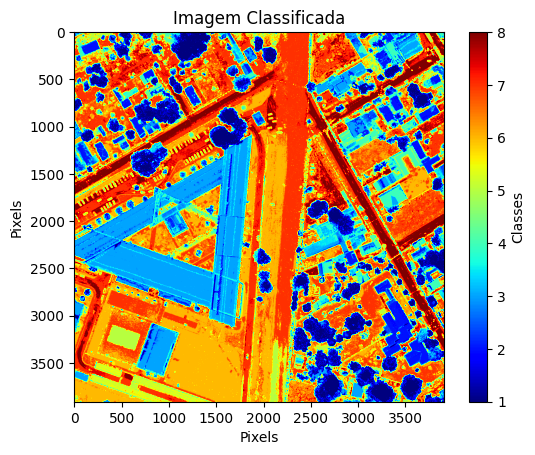

In [ ]:
# Mapear os rótulos de classe para valores numéricos
class_mapping = {
    'Arvore': 1,
    'Telhado(Ceramica)': 2,
    'Telhado': 3,
    'Telhado(Eternit)': 4,
    'Outro': 5,
    'Grama': 6,
    'Chao': 7,
    'Asfalto': 8
}

# Função para obter valores numéricos com um valor padrão de 0 para rótulos não mapeados
def map_class(label):
    return class_mapping.get(label, 0)

# Converter os rótulos para valores numéricos usando o mapeamento
classified_image_arvore_decisao_numeric = [[map_class(label) for label in row] for row in classified_image_arvore_decisao]

# Convertendo a lista para um array 2D
classified_image_arvore_decisao_array = [list(map(int, row)) for row in classified_image_arvore_decisao_numeric]


import matplotlib.pyplot as plt

# Exibir a imagem classificada
plt.imshow(classified_image_arvore_decisao_array, cmap='jet')
plt.colorbar(label='Classes')
plt.title('Imagem Classificada')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.show()

# Abrir a imagem original (ortofoto) para obter o perfil
with rasterio.open("caminho/para/abrir/ortofoto_cortada.tif") as src:
    profile = src.profile

# Atualizar o perfil para refletir o novo dtype e count
profile.update(dtype=rasterio.uint8, count=1)

# Transpor a imagem classificada para garantir a orientação correta
classified_image_arvore_decisao_transposed = list(zip(*classified_image_arvore_decisao_array[::1]))

# Salvar a imagem classificada com o perfil atualizado
with rasterio.open('caminho/para/salvar/classificacao_multiclasse_conjunto1.tif', 'w', **profile) as dst:
    dst.write(np.array(classified_image_arvore_decisao_transposed, dtype=np.uint8), 1)

Salvar imagem em formato PNG

In [ ]:
plt.imsave('caminho/para/salvar/classificacao_multiclasse_conjunto1.png', classified_image_rf_uint8, cmap='jet')

